## Afternoon practical day 2

Welcome to the final practical of today. Here you will implement multi-class logistic regression before moving on to forward propagation for your very own neural network. For the latter, we'll be working with the well-known MNIST dataset that contains images of handwritten digits that need to be classified. First, run the two cells below, and work on the 2D dataset in which you can clearly show the decision boundary learned.



In [1]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display, Markdown
from scipy.optimize import fmin_bfgs, fmin_cg, fmin
import sklearn

In [2]:
#important functions
def mySigmoid(data):
    data= np.array(data)
    output = 1/(1+ np.exp(-data))
    return output

def linAlgRegHypothesis(data, thetas):
    data = np.array(data)
    oneFeatToAdd = np.ones(len(data))
    newFeatArray = np.c_[oneFeatToAdd, data]
    #make sure thetas are always of the form np.array([[theta1], [theta2]]), i.e. column vector
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    predictions = newFeatArray @ thetas
    #print(predictions)
    return predictions

def linAlgLogRegHypothesis(data, thetas):
    output = mySigmoid(linAlgRegHypothesis(data, thetas))
    return output

def costFuncLogReg(thetas, x, y, lambda_ = 0, smallValueToPreventInfinity = 1e-12):
    m = len(x)
    predictions      = linAlgLogRegHypothesis(x, thetas)
    #print(predictions+smallValueToPreventInfinity)
    #print(-y * np.log(predictions+smallValueToPreventInfinity))
    #print(-y * np.log(predictions))
    costsPerSample   = -y * np.log(predictions+smallValueToPreventInfinity) - (1-y) * np.log(1 - (predictions+smallValueToPreventInfinity))
    #set the bias to 0 so you don't count it in regularisation.
    #It is convention not to regularise the bias/intercept
    thetas[0]        = 0
    regCost          = lambda_/2 * 1/m * thetas.T @ thetas
    totalCosts       = 1/m * np.nansum(costsPerSample) + regCost
    totalCosts       = np.ravel(totalCosts)
    #print(totalCosts)
    return totalCosts

def computeGradients(thetas, x, y, lambda_ = 0, hypothesis = 'linAlgLogRegHypothesis'):
    m = len(x)
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    preds  = globals()[hypothesis](x, thetas)
    if preds.shape != (m, 1):
        preds  = preds[:, np.newaxis]
    if y.ndim < 2:
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]
    unregularisedGradients  = 1/m * gradientSummation
    regularisedGradients    = np.ravel(unregularisedGradients)
    #print(regularisedGradients)
    regularisedGradients[1:]    = regularisedGradients[1:] + lambda_/m * np.ravel(thetas)[1:]
    #print(regularisedGradients)
    return regularisedGradients

def gradientDescentStep(thetas, gradients, alpha):
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    if gradients.ndim < 2:
        gradients = gradients[:, np.newaxis]
    newThetas = thetas - alpha * gradients
    return newThetas

def makeCrossValData(dataFrame, k=10):
    '''function to make splits into training and validation sets.
    Outputs two lists of length k, where each element is the indices of samples to train on for that fold, 
    and the indices of samples to test on for that fold, respectively.'''
    #shuffle data
    dataFrame = dataFrame.sample(frac=1)
    m = len(dataFrame)
    #see how many equal-sized sets you can make
    dataPerSplit = int(np.floor(m/k))
    dataPartitions = []
    counter = 0

    for i in range(0,k):
        #make a list of all the samples for each fold
        dataPartitions.append(list(range(counter,counter+dataPerSplit)))
        counter += dataPerSplit

    samplesEquallySplit = k * dataPerSplit
    if not samplesEquallySplit == m:
        #after making equal splits there will be samples left, i.e. you cannot always make k exactly evenly sized subsets.
        #randomly assign left over samples to folds after
        toDivide = m-samplesEquallySplit
        for extraSampleIndex in range(counter, counter+toDivide):
            #only assign to lists of samples that have the current minimum amount of samples
            currentSubsetSizes = np.array([len(subset) for subset in dataPartitions])
            assignTo = np.random.choice(np.where(currentSubsetSizes == np.min(currentSubsetSizes))[0])
            dataPartitions[assignTo].append(extraSampleIndex)
    
    #Now make the final cross-validation set: make k sets, each set has (k-1)/k folds to train on, and 1 fold to test on.
    testSet = []
    trainSet = []
    for validationSetIndex in range(0,k):
        #put 1 fold in the test set
        testSet.append(dataPartitions[validationSetIndex])
        #put all other folds in the train set
        trainSet.append(dataPartitions.copy())
        trainSet[validationSetIndex].pop(validationSetIndex)
        #this line makes sure all training set indices are in one big list, rather than k-1 small lists. 
        trainSet[validationSetIndex] = [item for sublist in trainSet[validationSetIndex] for item in sublist]
    
    return dataFrame, trainSet, testSet



def createNormalisedFeatures(dataFrame, mode = "range"):
    featureMeans = dataFrame.mean()
    if mode == "range":
        featureRanges = dataFrame.max() - dataFrame.min()
        normalisedFeatures = (dataFrame - featureMeans)/featureRanges
        return [normalisedFeatures, featureMeans, featureRanges]
    elif mode == "SD":
        featureSDs = dataFrame.std()
        normalisedFeatures = (dataFrame - featureMeans)/featureSDs
        return [normalisedFeatures, featureMeans, featureSDs]
    return None

def getDecisionBoundaryYValues(feat1, thetas):
    """Returns the y values for a decision boundary based on thetas for a 2D logistic regression problem"""
    thetas = np.ravel(thetas)
    b, w1, w2 = thetas
    intercept = -b/w2
    gradient  = -w1/w2
    yValues   = gradient * feat1 + intercept
    return yValues

## Multiclass (one-vs-all) classification with logistic regression

For multiclass classification the labels are no longer just 1 or 0, but can be from 0 to _n_.

During training, you loop over the number of labels, training a classifier for each. So you train a classifier to discern class 1 from not-1, class 2 from not-2, etc. Below, I generate some data for you to work on and plot it. After that, you're asked to train 5 classifiers on this data. 

,APRX-Y expression,MYC expression,Class
0,3.699656,0.681281,1.0
1,1.528104,4.769278,4.0
2,0.337536,4.201619,1.0
3,0.470636,0.554148,3.0
4,-7.374494,-5.855601,1.0


<AxesSubplot:xlabel='APRX-Y expression', ylabel='MYC expression'>

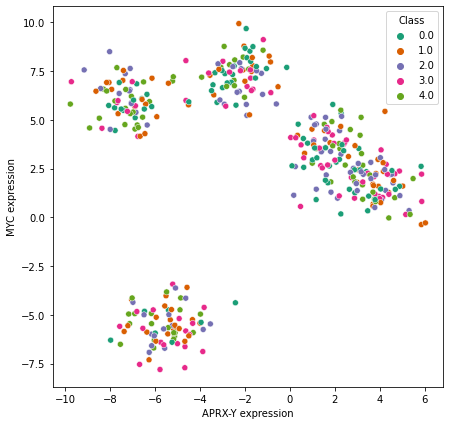

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

features, labels = make_blobs(n_samples = 500, n_features = 2, centers = 5, center_box = (-8, 8), 
                             random_state = 42)

features = pd.DataFrame(features)
#make train and test set
#make sure that the proportion of each class in the train and test set is equal
featsTrain, featsTest, labelsTrain, labelsTest = train_test_split(features, labels, test_size = 0.2, stratify = labels)
#normalise the data
featsTrain, muFeatsTrain, rangeFeatsTrain = createNormalisedFeatures(featsTrain, "range")
featsTrain = np.array(features)
featsTest  = (featsTest - muFeatsTrain)/rangeFeatsTrain
#note how you normalise the training data, and then use the obtained means and ranges to transform the test data!

#Show the data
dataFrameFiveClasses = pd.concat([pd.DataFrame(featsTrain), pd.DataFrame(labelsTrain)], axis = 1)
dataFrameFiveClasses.columns   = ["APRX-Y expression", "MYC expression", "Class"]
display(dataFrameFiveClasses.head())

#Make a plot of the training data using Seaborn
fig, ax = plt.subplots(figsize = (7,7))
sns.scatterplot(x = "APRX-Y expression", y = "MYC expression", hue = "Class", data = dataFrameFiveClasses,
               palette= "Dark2", ax = ax)

#train logistic regression on this

## Doing multiclass logistic regression

Now it is up to you to perform multiclass logistic regression. For now let's not use regularisation. To do this, do the following:

* Make a list of thetas `finalThetasEachClass`.
* Loop over the labels (there should be 5 iterations)
* In each loop:
    * Make a new class array, that is 1 for the current class under consideration, and 0 for all others (use the training data).
    * Use this class array to train logistic regression. Rather than using gradient descent, use `fmin_bfgs`.
    * Append the final thetas to the list.
* When that's done, use `np.vstack()` on the list to get a matrix of thetas, where each row are the learned parameters for discerning a certain class from all others.

In [4]:
startThetas = np.array([0]*3) #2 features and intercept

#answer
xx, yy = np.mgrid[-1:1:.001, -1:1:.001]
grid = np.c_[xx.ravel(), yy.ravel()]
finalThetasEachClass = []
for label in np.unique(np.sort(labelsTrain)):
    print(label)
    currentClassArray = (labelsTrain == label).astype(int)
    print(currentClassArray)
    #optimisedThetas   = fmin_cg(costFuncLogReg, startThetas, computeGradients, (featsTrain, currentClassArray))
    #optimisedThetas   = fmin_bfgs(f = costFuncLogReg, x0 = startThetas, args = (featsTrain, currentClassArray), full_output=True)
    optimisedThetas   = fmin(costFuncLogReg, startThetas, (featsTrain, currentClassArray))
    finalThetasEachClass.append(optimisedThetas)
    print(finalThetasEachClass[-1])
    probs = linAlgLogRegHypothesis(grid, optimisedThetas).reshape(xx.shape)
    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=1)
    # see: https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression 
    #decisionBoundary = getDecisionBoundaryYValues(featsTrain[:,0], optimisedThetas)
    #ax.plot(featsTrain[:,0], decisionBoundary)





0
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1
 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1]
Optimization terminated successfully.
         Current function value: 250.746932
         Iterations: 64
         Function evaluations: 116
[ 0.          0.10209625 -0.11181938]
1
[1 0 

In [8]:
###################
##
## HEre I checked the cost function and prediction function manually. All seemed to work!
##
###################
thetas = np.array(startThetas)
x = featsTrain
y = (labelsTrain == 0).astype(int)
lambda_ = 0

m = len(x)
if thetas.ndim < 2:
    print("reshaping thetas")
    thetas = thetas[:, np.newaxis]
    #print(thetas)
preds  = linAlgLogRegHypothesis(x, thetas)
if preds.shape != (m, 1):
    print("reshaping predicted")
    preds  = preds[:, np.newaxis]
if y.ndim < 2:
    print("reshaping y")
    y = y[:, np.newaxis]
    #print(y)
errors = preds - y
gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]
unregularisedGradients  = 1/m * gradientSummation
regularisedGradients    = np.ravel(unregularisedGradients)
print(regularisedGradients)
#print(regularisedGradients)
regularisedGradients[1:]    = regularisedGradients[1:] + lambda_/m * np.ravel(thetas)[1:]
print(type(regularisedGradients))

thetaCopy = thetas.copy()
smallValueToPreventInfinity = 1e-12

m = len(x)
predictions      = linAlgLogRegHypothesis(x, thetas)
costsPerSample   = -y * np.log(predictions+smallValueToPreventInfinity) - (1-y) * np.log(1 - predictions+smallValueToPreventInfinity)
print(costsPerSample)
#set the bias to 0 so you don't count it in regularisation.
#It is convention not to regularise the bias/intercept
thetaCopy[0]     = 0
regCost          = lambda_/2 * 1/m * thetaCopy.T @ thetaCopy
totalCosts       = np.nansum(1/m * costsPerSample) + regCost
print(np.ravel(totalCosts))
print(type(totalCosts)) 

reshaping thetas


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 65 is different from 3)

## Multiclass classification on MNIST

It's nice to have a baseline of performance before we move on to a neural network. So we can also run a multiclass logistic regression on the MNIST dataset. This means that in this case you get a matrix of theta values, one set for each class. The MNIST data consists of 8 \* 8 grayscale images, i.e. 64 values between 0-16 that indicate the intensity of a pixel (0=black, 16 = white). To make this matrix of values into something logistic regression can work with, we simply paste the rows of pixel intensities one after the other into a 1 by 64 row vector. After the 10 classifiers have been trained, you predict with all of them on the test data, and then simply pick the highest probability among them as the class to predict for that digit.

Below we load in the data and show some digits. After that, you're asked to train the 10 classifiers you need and predict on the test set.

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,178,182,177,183,181,182,181,179,174,180


Amount of samples per digit train:


,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,142,145,142,146,145,146,145,143,139,144


Amount of samples per digit test:


,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,36,37,35,37,36,36,36,36,35,36


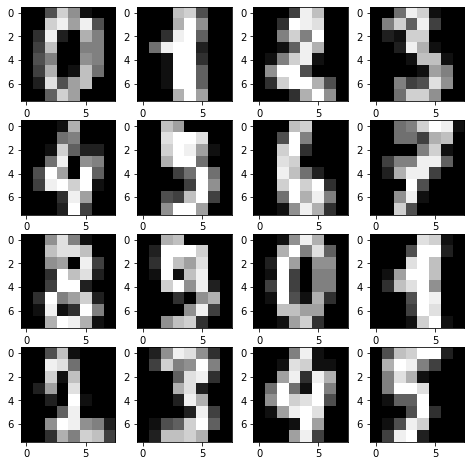

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
mnistData = load_digits()
print(mnistData.DESCR)
print("\n________________________________________\n")

print("Amount of samples per digit:")
display(pd.DataFrame(np.unique(mnistData.target, return_counts = True)))

#plot first 16 images
fig, axes = plt.subplots(4, 4, figsize = (8,8))
counter = 0
for imageRow in range(0,4):
    for imageCol in range (0,4):
        axes[imageRow, imageCol].imshow(mnistData.images[counter], cmap='gray', vmin = 0, vmax = 16, interpolation='none')
        counter += 1

#split the data into train and test, keeping class percentage equal, using a function from scikit-learn
x, y                                          = load_digits(return_X_y= True)
X_train, X_test, y_train, y_test              = train_test_split(x, y, train_size = 0.8, stratify = y)
normalised_X_train, means_train, ranges_train = createNormalisedFeatures(X_train, "range")
normalised_X_train                            = np.array(normalised_X_train)
normalised_X_test                             = (X_test - means_train)/ranges_train

print("Amount of samples per digit train:")
display(pd.DataFrame(np.unique(y_train, return_counts = True)))
print("Amount of samples per digit test:")
display(pd.DataFrame(np.unique(y_test, return_counts = True)))





## Performing multiclass (one-vs-all) logistic regression on MNIST

Okay, now it is up to you to perform multiclass logistic regression. It's the exact same procedure as before. Here are the instructions again if you need them:

* Make a list of thetas `finalThetasEachDigit`.
* Loop over the labels (there should be 10 iterations)
* In each loop:
    * Make a new class array, that is 1 for the current digit under consideration, and 0 for all others (use the training data).
    * Use this class array to train logistic regression. Rather than using gradient descent, use `fmin_bfgs`.
    * Append the final thetas to the list.
* When that's done, use `np.vstack()` on the list to get a matrix of thetas, where each row are the learned parameters for discerning a certain digit from all others.

In [7]:
startThetas = [12]*65 #64 pixels and the intercept parameter

print(y_train)

#answer
finalThetasEachDigit = []
for label in np.unique(y_train):
    currentClassArray = (y_train == label).astype(int)
    optimisedThetas   = fmin_bfgs(costFuncLogReg, startThetas, computeGradients, (normalised_X_train , currentClassArray))
    finalThetasEachDigit.append(optimisedThetas)
    break
    

<ipython-input-2-c51cee75f496>:28: RuntimeWarning: invalid value encountered in log
  costsPerSample   = -y * np.log(predictions+smallValueToPreventInfinity) - (1-y) * np.log(1 - (predictions+smallValueToPreventInfinity))
<ipython-input-2-c51cee75f496>:28: RuntimeWarning: invalid value encountered in log
  costsPerSample   = -y * np.log(predictions+smallValueToPreventInfinity) - (1-y) * np.log(1 - (predictions+smallValueToPreventInfinity))


         Current function value: 7369.270410
         Iterations: 0
         Function evaluations: 77
         Gradient evaluations: 69


## Neural networks introduction (~60 minutes)

That's it for logistic regression. Now let's move on to neural networks, which, with the sigmoid activation function we use in them, are layered logistic regressors. In this way, they can extract basic features, then make some intermediate feature representations that help final classification, and then perform that final classification. Before you move on to the actual practical exercises at hand, it probably wouldn't hurt to reinforce what we've covered in the lectures. 3Blue1Brown has four _fantastic_ videos about neural networks. Watch the first 2 now:<br>
* [But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=1)
* [Gradient descent, how neural networks learn](https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2)

After you're done with that, spend some 15 minutes playing around on the online TensorFlow playground, and try to understand what's going on with the neural network there. Of course, you don't know how it's learning, but you can see how it works visually, which is always a great aid. Be sure to scroll down first and read what blue and orange mean: <br>

* [TensorFlow playground](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,3,2&seed=0.86244&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)




## Implementing feedforward neural networks yourself

The image below was ~shamelessly ripped from~ taken from a practical on forward propagation by Andrew Ng on Coursera. It shows the neural network that we're going to use to perform our predictions with:
![NeuralNetworkImage](NeuralNetwork.PNG)

We'll give our 8\*8 data to the input units, shown in blue. This means that there are 64 input units (excluding the bias unit that always just outputs +1). Just to be clear: what are shown as, and called, input _units_ are just the _feature values_. There's no computation in the blue circles.

Then, there's a Hidden Layer consisting of 25 units (and the bias unit with the +1), and a final layer with 10 output units, that calculate the hypothesis function for each digit (i.e. chance that it is a 0, a 1, a 2, etc.).

You're given two _matrices_ of trained weights, $\Theta_1$ and $\Theta_2$. It'll be up to you to do the computations that finally result in the output of the neural network. Do this computation for the normalised_X_train from above. While we're not going to train the neural network here, remember that we now have our labels as (row) vectors. <br>
So, the digit 0 has as label: $$\begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \end{bmatrix}$$
While the digit 5 has as label: $$\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \end{bmatrix}$$ <br>
Transform the labels in this way using numpy or sklearn (OneHotEncoder) (your call).

So, your task:
* Transform the numeric scalar labels (0-9) into vector labels (see above) using numpy or sklearn. Using OneHotEncoder from sklearn with `sparse = False` and using `.fit_transform(labelsToTransform)` is probably easiest.
* Perform the computations with the two theta matrices such that you go from all the inputs (`normalised_X_train`) to the correct outputs. Don't forget to add bias units (i.e. a 1), and don't forget the activation function (sigmoid)! Make sure to do this with linear algebra: no loops! Finally: the HL has 25 units and the output layer 10 units.
* Once done, make the outcomes classifications (by setting the maximal outcome of the 10 output units as 1, and the rest as 0 in the predicted label)
* Then, check how many train samples are correctly predicted by these trained weight matrices (check whether the output labels are completely equal to the predicted labels).
* Once you're done, check the answers for some code to plot the misclassified samples and their predicted class.

Hints:
* If you get errors about needing to reshape, do exactly as they say.
* The Theta matrices contain the bias and the weights per unit in rows. So: the first row of $\Theta_1$ contains the bias in the first column, and then the 64 weights for the 64 pixels in the following columns.
* You might need to transpose (`.T`) things here to get the desired behaviour. 
* Check the slides for inspiration
* Remember to use `@` for matrix multiplication
* You can use `np.c_[]` in combination with `np.ones()` to append a column of all 1 to the inputs to a layer. Note: to make np.ones  return a column vector, make sure to set its `shape` argument to `(someDimension, 1)`
* To change the outcomes to class vectors, you can loop over the samples, set the maximum to 1 and the rest to 0, or do everything together with `np.where()` and `np.amax(theData, axis = 1)`.
* You might need `np.all(classLabelsPredicted == realClassLabels, axis = 1)`


Shape of weighted sum: 
(1437, 25)
This is correct: we now have for the 1437 samples a weighted sum, with the sum made by each unit (25 total) using its bias and weights in the columns
Shape of activations final layer:
(1437, 10)
That's as we expect, 1437 times 10 predictions!

Let's look at the first 2 samples:
[[1.48503815e-06 8.41640098e-02 1.36993834e-03 2.79880623e-04
  4.16293437e-04 5.01384302e-05 1.88313202e-04 1.26532334e-04
  3.82990587e-03 7.25992888e-05]
 [7.61274747e-04 2.44663381e-05 6.36253373e-05 1.01126766e-03
  5.35098573e-06 2.17020839e-04 4.83557346e-05 3.03601464e-04
  1.66307676e-03 1.69711002e-02]]
You see that the values are very small, but the predictions are nevertheless correct.
The maximal elements for sample 0 and 1 are:
[[0 1]
 [1 9]]
The actual labels for those digits are:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Or as numbers:
[1 9]
Nice to know that I didn't mess up the training of the network and saddle you with poor parameter

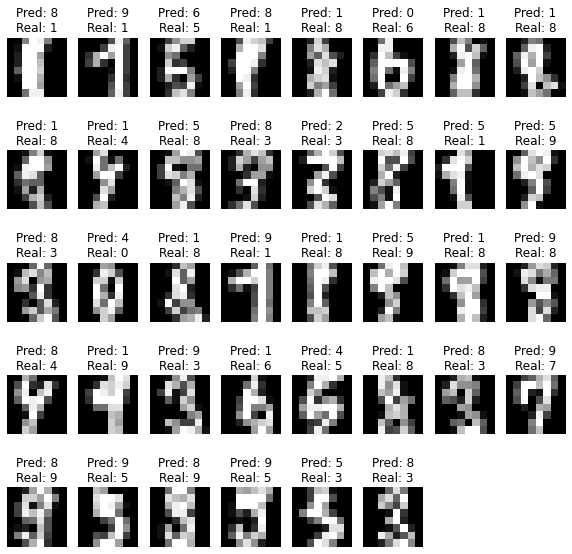

In [152]:
thetaOneMatrix = np.loadtxt("thetaOneMatrixFFNN.csv", delimiter = ",")
thetaTwoMatrix = np.loadtxt("thetaTwoMatrixFFNN.csv", delimiter = ",")

#Your code here. Use normalised_X_train!



#answer

y_train_vector         = sklearn.preprocessing.OneHotEncoder(categories = "auto", sparse = False).fit_transform(y_train.reshape(-1,1))
y_test_vector          = sklearn.preprocessing.OneHotEncoder(categories = "auto").fit_transform(y_test.reshape(-1,1))

xInputs                = np.c_[np.ones(shape = (len(normalised_X_train), 1)), normalised_X_train]

firstLayerWeightedSum  =  xInputs @ thetaOneMatrix.T
print("Shape of weighted sum: ")
print(firstLayerWeightedSum.shape)
print("This is correct: we now have for the 1437 samples a weighted sum, with the sum made by each unit (25 total) using its bias and weights in the columns")
firstLayerActivations  = mySigmoid(firstLayerWeightedSum)

secondLayerInputs      = np.c_[np.ones(shape = (len(firstLayerActivations), 1)), firstLayerActivations]
secondLayerWeightedSum = secondLayerInputs @ thetaTwoMatrix.T


#these are our 10 hypothesis functions, 1 for each class
secondLayerActivations = mySigmoid(secondLayerWeightedSum)
print("Shape of activations final layer:")
print(secondLayerActivations.shape)
print("That's as we expect, 1437 times 10 predictions!\n")

print("Let's look at the first 2 samples:")
print(secondLayerActivations[0:2, :])

print("You see that the values are very small, but the predictions are nevertheless correct.")
print("The maximal elements for sample 0 and 1 are:")
print(np.vstack(np.where(np.amax(secondLayerActivations[0:2, :], axis = 1)[:,np.newaxis] == secondLayerActivations[0:2, :])))
print("The actual labels for those digits are:")
print(y_train_vector[0:2,:])
print("Or as numbers:")
print(y_train[0:2])
print("Nice to know that I didn't mess up the training of the network and saddle you with poor parameters!")


#changing the outcome to classification vectors
outcomeCopy         = secondLayerActivations.copy()
outcomeClassVectors = np.where(np.amax(secondLayerActivations[:, :], axis = 1)[:,np.newaxis] == secondLayerActivations[:, :], 1, 0)

#checking whether the results are the collect labels
classificationCorrect = np.all(outcomeClassVectors == y_train_vector, axis = 1)
print("Correctly classified in the training data: " + str(np.sum(classificationCorrect)))
print("Incorrectly classified in the training data: " + str(np.sum(~classificationCorrect)))

print("Let's plot the samples where we were incorrect and our faulty predictions:")
wrongSampleIndices = np.ravel(np.where(~classificationCorrect))
figWrongPreds, axWrongPreds = plt.subplots(5, 8, figsize = (10,10))
sampleOne = normalised_X_train[0,:].reshape(8,8)
counter = 0
for row in range(0,5):
    for col in range(0,8):
        if counter >= len(wrongSampleIndices):
            break 
        axWrongPreds[row, col].imshow(normalised_X_train[wrongSampleIndices[counter],:].reshape(8,8),
                                      cmap = "gray", interpolation = "none")
        axWrongPreds[row, col].set_title("Pred: " + str(np.where(outcomeClassVectors[wrongSampleIndices[counter],:] == 1)[0][0]) + "\n" + "Real: " + str(y_train[wrongSampleIndices[counter]]))
        axWrongPreds[row, col].set_axis_off()
        counter += 1
for subPlotToDelete in [38, 39]:
    figWrongPreds.delaxes(axWrongPreds.flatten()[subPlotToDelete])
    
print("These are pretty difficult, especially with this small resolution.")

Repeat of the network image for your convenience:
![NeuralNetworkImage](NeuralNetwork.PNG)

## What comes now can be freely picked

With such an enticing sub-heading I assume you're basically foaming at the mouth to pick what you want to do. Turns out, 'freely' was slightly overstated and there's basically four options:

1. Finish what might not have gotten finished before, any practical exercises from yesterday or earlier today that you didn't quite get to. <br> <br>
2. Read or watch more about what we discussed these two days to review (or preview the next few days): consult the course reader for recommendations. <br> <br>
3. Do the sneak preview exercise on scikit-learn below. You might have seen me use it to make some datasets, and you'll be using it next week, so you could use this time to get a little hands-on practice in already. <br> <br>
4. Leave this place of learning, so to gain more free time to fill with whatever pleasure and/or debauchery suits your whims!


## Optional scikit-learn preview

Hi there, welcome to this optional part that's optional. Did I mention it's optional? Wouldn't want to overwelm anyone with **optional** materials. Without further ado:

Yesterday you traded some of your precious little time on this planet to painstakingly implement gradient descent for linear regression yourself, and you did so this morning for logistic regression too. Turns out that's a sucker's game, because extremely cool and knowledgeable people have already put together a whole library that implements all sorts of ML algorithms, which allows you to train classifiers with very little code. 

To use this wealth of power, simply import scikit-learn as sklearn and get going. Note that sklearn's predictors have methods that you'll work with to fit them to data and to predict on unseen data. As an example, a Random Forest implementation would look something like this: <br> <br>
`
myRandomForest = sklearn.ensemble.RandomForestClassifier(n_estimators = 80, max_depth = 2)
myRandomForest.fit(trainingFeatures, trainingLabels)
#predict class labels
myRandomForest.predict(testFeatures)
#predict class probabilities
myRandomForest.predict_proba(testFeatures)
#see the cost function/score (mean accuracy here)
myRandomForest.score(testFeatures, testLabels)
` <br> <br>
Your first order of business is to implement linear regression.   To do this:

* Import sklearn 
* Load the California housing dataset (look in [sklearn.datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)). Be sure to do `from sklearn import datasets` as well!
* Print exactly what the targets mean (what are the units of what you're predicting?), what the number of samples is, and use `DataFrame.describe()` to see the mean and distribution of the features (you'll need to convert to a DataFrame for that).
* Split the normalised data into train and test sets ( 80%, 20%, look [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).
* Normalise both features and the target to have zero mean and unit variance. Use [StandardScaler](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling). **Note: If you normalise train and test data together, information about the mean and variance of the test data 'leaks' into the transformed data: you've used aspects of the test data in transforming the train data. The correct way is to transform the train data, and then use the mean and variance calculated there to transform the test data. The StandardScaler link shows how to do this**
* Train linear regression without regularisation, and test on the test set. Print the $R^2$ (use `.score`). Also print the learned parameters/weights (use `.coef_`).
* Train linear regression with L2 regularisation (penalising the sum of squares of the parameters). This is called Ridge regression. Set its $\lambda$ (which is confusingly called alpha) to 1.  Test on the test set and print the $R^2$ (use `.score`). Also print the learned parameters/weights (use `.coef_`).
* Train linear regression with L1 regularisation (penalising the sum of the absolutes of the parameters). This is called LASSO regression. Set its $\lambda$ (which is confusingly called alpha) to 0.01. Test on the test set and print the $R^2$ (use `.score`). Also print the learned parameters/weights (use `.coef_`).

Hints:
* It seems like a lot of steps, but it's all basically one-liners in sklearn (okay some are three-liners).
* Search the documentation for the right predictor or functionality. You'll have to learn to navigate it anyway!
* If you don't know what $R^2$ is, see [this](https://www.youtube.com/watch?v=2AQKmw14mHM).

In [50]:
#answer
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

featuresHousing, targetsHousing = sklearn.datasets.fetch_california_housing(return_X_y = True)

#see here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset 
print("The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).")
print("Number of samples: " + str(len(featuresHousing)))
display(pd.DataFrame(featuresHousing).describe())

#split
featsHouseTrain, featsHouseTest, targetsHouseTrain, targetsHouseTest = train_test_split(featuresHousing, targetsHousing,
                                                                                        random_state = 42,
                                                                                        test_size = 0.2)
#normalise
#for this transformer, fitting means 'calculate the means and variances with which to perform the scaling'
scalerFeats = preprocessing.StandardScaler().fit(featsHouseTrain)
print("Feature means: " + str(scalerFeats.mean_))
print("Feature std: " + str(scalerFeats.scale_))
print("The slight mismatch in std between pandas and the scaler is probably\nin the way the standard deviation is calculated (either divided by n or by n-1)")
#transforming is where we actually take the original features, remove the means, and divide by the standard deviation.
scaledFeatsTrain, scaledFeatsTest = scalerFeats.transform(featsHouseTrain), scalerFeats.transform(featsHouseTest)

#ow for the targets
#reshape because the error message told me to: StandardScalar wants columns with values over which to perform.
scalerTargets = preprocessing.StandardScaler().fit(targetsHouseTrain.reshape(-1,1))
scaledTargetsTrain, scaledTargetsTest = scalerTargets.transform(targetsHouseTrain.reshape(-1,1)), scalerTargets.transform(targetsHouseTest.reshape(-1,1))
#make targets 1D again
scaledTargetsTrain, scaledTargetsTest = np.ravel(scaledTargetsTrain), np.ravel(scaledTargetsTest)

print("-----------------")
print("Scaled targets:")
print(scaledTargetsTrain)

#fit normal linear regression
linearRegressor             = LinearRegression().fit(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionTrain = linearRegressor.score(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionTest  = linearRegressor.score(scaledFeatsTest, scaledTargetsTest)
print("Normal linear regression:")
print("Train R^2: " + str(scoresLinearRegressionTrain))
print("Test R^2 : "  + str(scoresLinearRegressionTest))
print("Learned Parameters: " + str(linearRegressor.coef_) + "\n")

#L2 Regularised:
linearRegressorRidge             = Ridge(alpha = 1).fit(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionRidgeTrain = linearRegressorRidge.score(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionRidgeTest  = linearRegressorRidge.score(scaledFeatsTest, scaledTargetsTest)
print("Ridge regression:")
print("Train R^2: " + str(scoresLinearRegressionRidgeTrain))
print("Test R^2 : " + str(scoresLinearRegressionRidgeTest))
print("Learned Parameters: " + str(linearRegressorRidge.coef_) + "\n")

#L1 Regularised
linearRegressorLasso             = Lasso(alpha = 0.01).fit(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionLassoTrain = linearRegressorLasso.score(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionLassoTest  = linearRegressorLasso.score(scaledFeatsTest, scaledTargetsTest)
print("Lasso regression:")
print("Train R^2: " + str(scoresLinearRegressionLassoTrain))
print("Test R^2 : " + str(scoresLinearRegressionLassoTest))
print("Learned Parameters: " + str(linearRegressorLasso.coef_) + "\n")

The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).
Number of samples: 20640


,0,1,2,3,4,5,6,7
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Feature means: [ 3.88075426e+00  2.86082849e+01  5.43523502e+00  1.09668475e+00
  1.42645300e+03  3.09696119e+00  3.56431492e+01 -1.19582290e+02]
Feature std: [1.90423626e+00 1.26021177e+01 2.38730258e+00 4.33201426e-01
 1.13702195e+03 1.15783935e+01 2.13660060e+00 2.00559281e+00]
The slight mismatch in std between pandas and the scaler is probably
in the way the standard deviation is calculated (either divided by n or by n-1)
-----------------
Scaled targets:
[-0.90118909  1.5127714  -0.29921255 ...  0.12891731  0.65997132
  1.01890847]
Normal linear regression:
Train R^2: 0.6125511913966952
Test R^2 : 0.5757877060324508
Learned Parameters: [ 0.73896341  0.10599132 -0.25463792  0.29342852 -0.00199597 -0.03531345
 -0.77576169 -0.75233381]

Ridge regression:
Train R^2: 0.6125511218634558
Test R^2 : 0.5758157428913682
Learned Parameters: [ 0.73891476  0.10605855 -0.25446513  0.29321095 -0.0019739  -0.03531684
 -0.77510324 -0.75166694]

Lasso regression:
Train R^2: 0.6071014476004367
Test

## Logistic regression

You probably found that was rather quick and easy compared to the laborious process of doing things yourself. Still, using slick functions from some package cannot be done well without knowledge of what's going on under the hood.

To finish this sneak preview, let's properly train logistic regression. That is: let's use cross-validation rather than just train_test_split to get 5 estimates of how our classifier will perform on unseen data, and let's use internal cross-validation to search for hyperparameters. That probably needs some explanation:


## The end

Well done! You've done multiclass logistic regression and made your first steps towards understanding and implementing neural networks. 

## Survey
Who could forget? [Click](https://docs.google.com/forms/d/e/1FAIpQLSfnHr02yXCsyrUTfTeMCEay3wOZLOquY8FuQMIsnkopL_1PFQ/viewform?usp=sf_link)